In [2]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf

from tensorflow import keras
from keras import datasets, layers, models
if not tf.config.list_physical_devices("GPU"):
    print("No GPU was detected. DNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
import numpy as np
from scipy.optimize import check_grad
from sklearn.model_selection import train_test_split
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
import warnings
warnings.filterwarnings('ignore')
from typing import List
from tqdm import tqdm
try:
    from probml_utils.mnist_helper_tf import *
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils.mnist_helper_tf import *

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 7.8 MB/s 
     |████████████████████████████████| 132 kB 67.0 MB/s 
     |████████████████████████████████| 272 kB 12.7 MB/s 
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 121 kB 80.1 MB/s 
     |████████████████████████████████| 1.6 MB 65.8 MB/s 
     |████████████████████████████████| 83 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 63.3 MB/s 


### Task1: Acquire the data (Fashion-MNIST)

In [5]:
train_images, train_labels, test_images, test_labels, class_names \
           = get_dataset(FASHION=True)  # get Fashion-MNIST datasets


# vectorize pixels in the input features;  shape = (N,D)
train_images = train_images.reshape(train_images.shape[0],(train_images.shape[1]*train_images.shape[2])) 
test_images = test_images.reshape(test_images.shape[0],(test_images.shape[1]*test_images.shape[2])) 


# setting up unnormalized data first

unnormalized_train = train_images 
unnormalized_test = test_images


cov_train = np.dot(unnormalized_train.T,unnormalized_train) / unnormalized_train.shape[0]
U,S,V =np.linalg.svd(cov_train)

unnormalized_train = np.dot(unnormalized_train, U[:,:28])
unnormalized_test = np.dot(unnormalized_test, U[:,:28])

unnormalized_train, unnormalized_validation_images, unnormalized_train_labels, unnormalized_validation_labels = train_test_split(unnormalized_train,train_labels,test_size=10000)


# Normalize the training and test sets
train_images /= np.std(train_images, axis=0)
test_images /= np.std(test_images, axis=0)

# #subtracting the mean across every individual feature in the training and test sets
train_images_reduced = train_images- np.mean(train_images, axis=0)
test_images_reduced = test_images- np.mean(test_images, axis=0)


# # get the training and test data convariance matrix
cov_train = np.dot(train_images_reduced.T,train_images_reduced) / train_images_reduced.shape[0]
# cov_test = np.dot(test_images.T,test_images) / test_images.shape[0]

# # U= eigenvector S = 1-D array of the singular values
U,S,V =np.linalg.svd(cov_train)
# # U_test,S_test,V_test = np.linalg.svd(cov_test)


# #reduce the original dataset of size [N X (28*28)] to one of size [N X 28]
# #keeping the 100 dimensions of the data contain the most variance.
train_images_reduced = np.dot(train_images_reduced, U[:,:28])
test_images_reduced = np.dot(test_images_reduced, U[:,:28])

# #whiten the data
train_images_reduced = train_images_reduced / np.sqrt(28+1e-5)
test_images_reduced = test_images_reduced / np.sqrt(28+1e-5)

# splitting train images into test and validation set

train_images_reduced, validation_images, train_labels_reduced, validation_labels = train_test_split(train_images_reduced,train_labels,test_size=10000)



4422102/4422102 [==============================] - 0s 0us/step


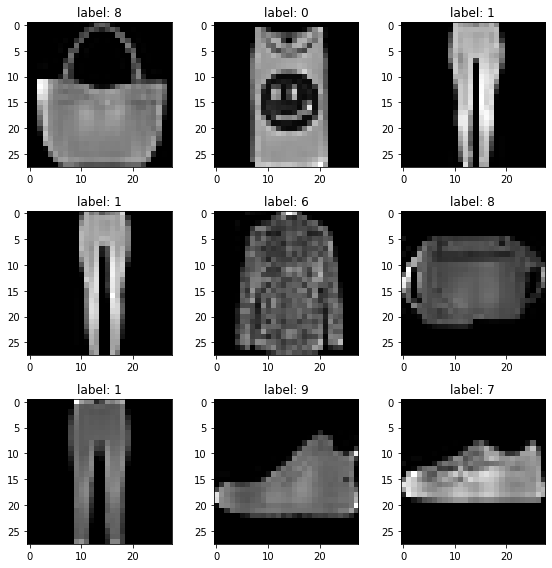

In [ ]:
#@title Data visualization

fig = plt.figure()
for i in  range(100, 109):
  fig.set_figwidth(8)
  fig.set_figheight(8)
  plt.subplot(3,3,i-99)
  plt.tight_layout()
  plt.imshow(train_images[i].reshape((28,28)), cmap='gray')
  plt.title(f'label: {train_labels[i]}')


Lenght of original training data 60000
Lenght of training data 50000
Lenght of Validation data 10000
Lenght of Test data 10000
Lenght of original training data (784,)


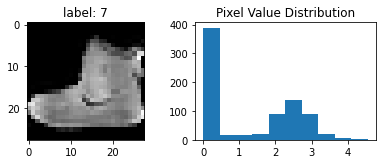

In [ ]:
fig.set_figwidth(8)
fig.set_figheight(8)
plt.subplot(2,2,1)
plt.tight_layout()
plt.imshow(train_images[0].reshape((28,28)), cmap='gray')
plt.title(f'label: {train_labels[i]}')

plt.subplot(2,2,2)
plt.hist(train_images[0].reshape(784))
plt.title("Pixel Value Distribution")

print("Lenght of original training data", len(train_images)) #5000 + 1000 = 6000
print("Lenght of training data", len(train_images_reduced)) #5000
print("Lenght of Validation data", len(validation_images)) #1000
print("Lenght of Test data", len(test_images))  #10000
print("Lenght of original training data", train_images[00].shape) #total of 28**2 pixels

### Task2: Implement an MLP to classify image data

#### Neural Network Layers

In [6]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = .5 * np.random.randn(output_size, input_size)
        self.b = .5 * np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]
    def get_grad(self, gradient):
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return self.gradient

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)

        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

class LinearLayerRegularized(NeuralNetLayer):
    def __init__(self, input_size, output_size, L):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = .5 * np.random.randn(output_size, input_size)
        self.b = .5 * np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]
    def get_grad(self, gradient):
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return self.gradient

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)

        dw = gradient[:, :, None] @ self.cur_input[:, None, :] + ((L/2) * self.w)
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient


class TanHLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        exps = np.exp(x)
        exps_n = np.exp(-x)
        z = (exps - exps_n)/(exps + exps_n)
        self.gradient = 1-z**2
        return z

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient
        
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        # x> 0 => 1, x == 0 => 0, x < 0 => α, α = 0.01
        self.gradient = np.where(x > 0, 1.0, np.where(x < 0, 0.01 , 0.0 )) 
        return np.maximum(0, x) + np.minimum(0, x * 0.01) # max(x, 0) + α min(x, 0)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient



class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

    def get_grad(self,target):
        return self.cur_probs - target


#### The MLP and Backpropagation

In [7]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
    
    def get_grad(self,target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
        grad = target
        return grad
        

    def check_grad(self,X,output):
        epsilon = 1e-7
        X=X+epsilon
        labels = np.eye(10)[np.array(output)]
        predictions = self.forward(X)
        loss = -(labels * np.log(predictions)).sum(axis=-1)
        grad = self.get_grad(labels).sum(axis=-1)

        X=X-(epsilon*2)
        predictions2 = self.forward(X)
        loss2 = -(labels * np.log(predictions2)).sum(axis=-1)
        gradapprox = (loss-loss2) / (2*epsilon)
        numerator = np.square((gradapprox-grad).sum())
        denominator =  np.square((gradapprox).sum()) + np.square((grad).sum())
        return numerator/denominator

    def fit(self, input, output, optimizer, max_iter, best_version):
        losses = []
        accuracies = []
        labels = np.eye(10)[np.array(output)]
        for _ in tqdm(range(max_iter)):
            predictions = self.forward(input)
            loss = -(labels * np.log(predictions)).sum(axis=-1).mean()
            losses.append(loss)
            self.backward(labels)
            optimizer.step()
            accuracies.append(self.evaluate_acc(output,self.predict(input)))

        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_figwidth(15), fig.set_figheight(5)

        if best_version:
          fig.suptitle('Accuracy and CE Loss on Test Data Using Best Hyperparameters')
          ax1.plot(accuracies, color='red')
          ax1.set_xlabel("Epoch")
          ax1.set_ylabel("Training Accuracy")
          ax1.title.set_text("Best Accuracy")
          ax2.plot(losses, color='blue')
          ax2.set_xlabel("Epoch")
          ax2.set_ylabel("Cross entropy loss")
          ax2.title.set_text('Cross Entropy Loss for Best Accuracy')
        else:
          ax1.plot(accuracies, color='red')
          ax1.set_xlabel("Epoch")
          ax1.set_ylabel("Training Accuracy")
          ax2.plot(losses, color='blue')
          ax2.set_xlabel("Epoch")
          ax2.set_ylabel("Cross entropy loss")

    def fit_SGD(self, input, output, optimizer, max_iter, batch_size):
      losses = []
      accuracies = []
      init = 0
      end = batch_size
      labels = np.eye(10)[np.array(output)]
      for _ in tqdm(range(max_iter)):
        while init < len(input):
          predictions = self.forward(input[init:end])
          loss = -(labels[init:end] * np.log(predictions)).sum(axis=-1).mean()
          losses.append(loss)
          self.backward(labels[init:end])
          optimizer.step()
          accuracies.append(self.evaluate_acc(output,self.predict(input)))
          init += batch_size
          end += batch_size
          if end > len(input):
            end = len(input)
      fig, (ax1, ax2) = plt.subplots(1,2)
      fig.set_figwidth(15), fig.set_figheight(5)

      fig.suptitle('Accuracy and CE Loss on Test Data Using Best Hyperparameters')
      ax1.plot(accuracies, color='red')
      ax1.set_xlabel("Epoch")
      ax1.set_ylabel("Training Accuracy")
      ax1.title.set_text("Best Accuracy")
      ax2.plot(losses, color='blue')
      ax2.set_xlabel("Epoch")
      ax2.set_ylabel("Cross entropy loss")
      ax2.title.set_text('Cross Entropy Loss for Best Accuracy')


      
    def fit_SGD_no_plot(self, input, output, optimizer, max_iter, batch_size):
      losses = []
      init = 0
      end = batch_size
      labels = np.eye(10)[np.array(output)]
      for _ in tqdm(range(max_iter)):
        while init < len(input):
          predictions = self.forward(input[init:end])
          loss = -(labels[init:end] * np.log(predictions)).sum(axis=-1).mean()
          losses.append(loss)
          self.backward(labels[init:end])
          optimizer.step()
          init += batch_size
          end += batch_size
          if end > len(input):
            end = len(input)
            
      
    def predict(self, input):
        return np.argmax(self.forward(input),axis=-1)

    def evaluate_acc(self,y_true, y_pred):
        return np.sum(y_pred==y_true)/len(y_pred)

In [8]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)



### Task 3 

#### Verify the gradients

In [ ]:
n_features=train_images_reduced.shape[-1]
model = MLP(
    LinearLayer(n_features, 10),
    SoftmaxOutputLayer()
)
opt = GradientDescentOptimizer(model, 1e-1)
diff = model.check_grad(train_images_reduced,train_labels_reduced)
print(diff)

2.5450776903898505e-10


###3.1

No Hidden Layer Regular GD

100%|██████████| 350/350 [00:48<00:00,  7.15it/s]



best learning rate (no hidden layer) = 0.1
train accuracy (no hidden layer) = 0.73686
validation accuracy (no hidden layer) = 0.752
test accuracy (no hidden layer) = 0.728


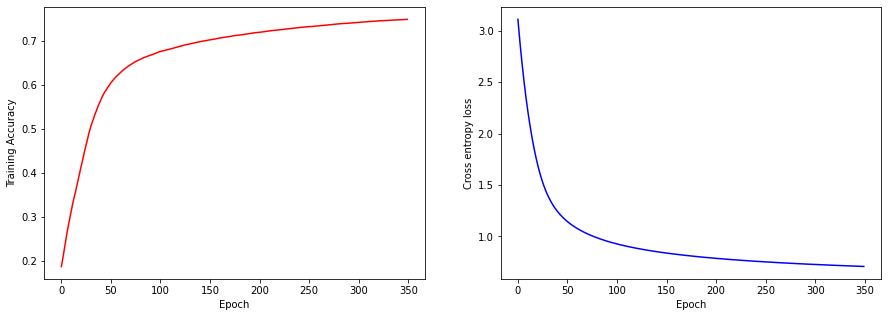

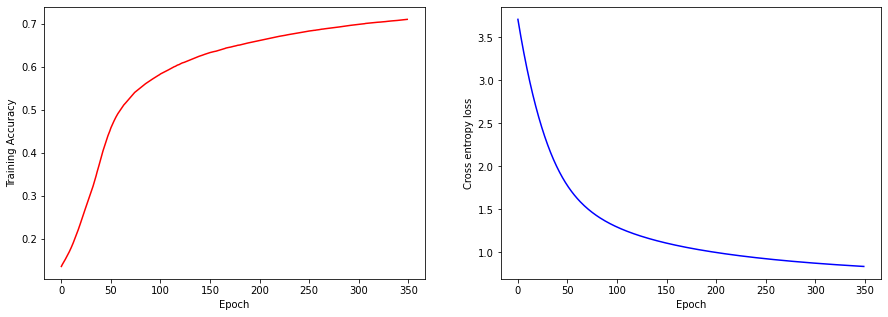

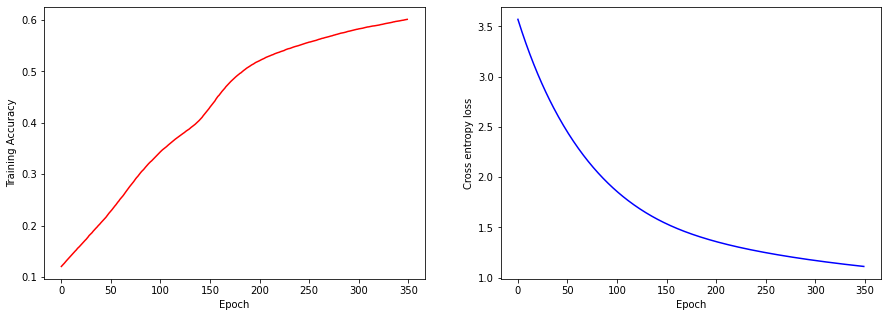

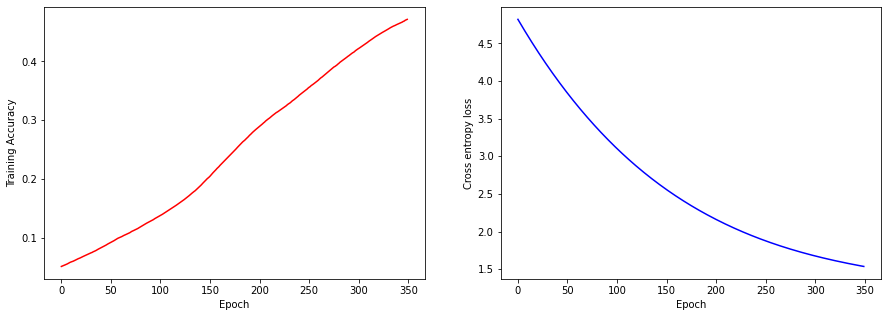

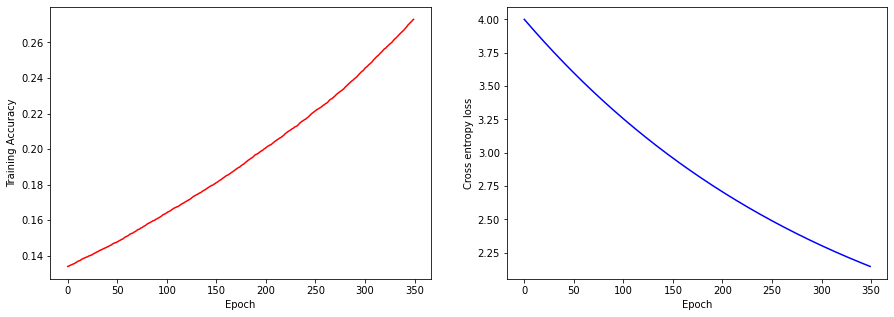

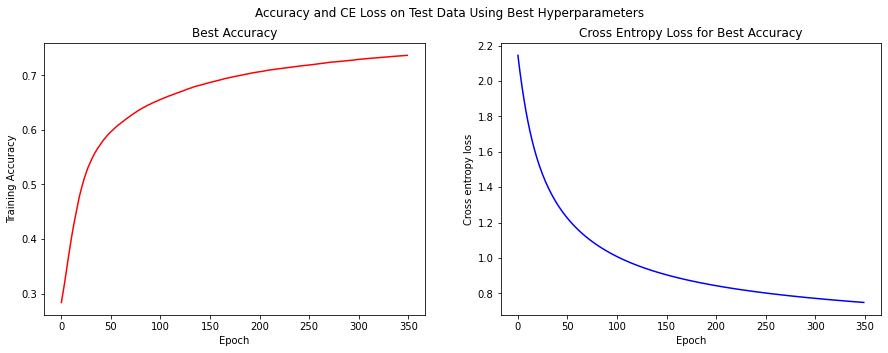

In [ ]:
max_iters = 350
n_features=train_images_reduced.shape[-1]

learning_rates = [.1,.05,.025,.01,.005,.001]
temp = (0,0)

for rate in learning_rates:
  #initializing new model and optimizer with different learning rate
  model = MLP(LinearLayer(n_features, 10),SoftmaxOutputLayer())
  opt1 = GradientDescentOptimizer(model, rate)
  #fitting new model
  model.fit(input= train_images_reduced, output= train_labels_reduced, optimizer=opt1, max_iter=max_iters, best_version = False)

  y_pred_valid = model.predict(input=validation_images)
  acc_valid= model.evaluate_acc(y_true=validation_labels ,y_pred= y_pred_valid)
  #updating tuple if validation accuracy is better than all previous attempts
  if acc_valid > temp[0]:
    temp = (acc_valid,rate)

#Fitting model with the best hyperparameters found and evaluating it on training and testing data
model = MLP(LinearLayer(n_features, 10),SoftmaxOutputLayer())
opt1 = GradientDescentOptimizer(model, temp[1])

model.fit(input= train_images_reduced, output= train_labels_reduced, optimizer=opt1, max_iter=max_iters, best_version= True)

y_pred_train = model.predict(input=train_images_reduced)
acc_train= model.evaluate_acc(y_true=train_labels_reduced ,y_pred= y_pred_train)

y_pred_test = model.predict(input=test_images_reduced)
acc_test = model.evaluate_acc(y_true=test_labels ,y_pred= y_pred_test)

print("")
print(f'best learning rate (no hidden layer) = {temp[1]}')
print(f'train accuracy (no hidden layer) = {acc_train}')
print(f'validation accuracy (no hidden layer) = {temp[0]}')
print(f'test accuracy (no hidden layer) = {acc_test}')


No Hidden Layer SGD

100%|██████████| 100/100 [01:31<00:00,  1.10it/s]



best learning rate (no hidden layer) = 0.1
best batch size (no hidden layer) = 10
train accuracy (no hidden layer) = 0.79834
validation accuracy (no hidden layer) = 0.7973
test accuracy (no hidden layer) = 0.7894


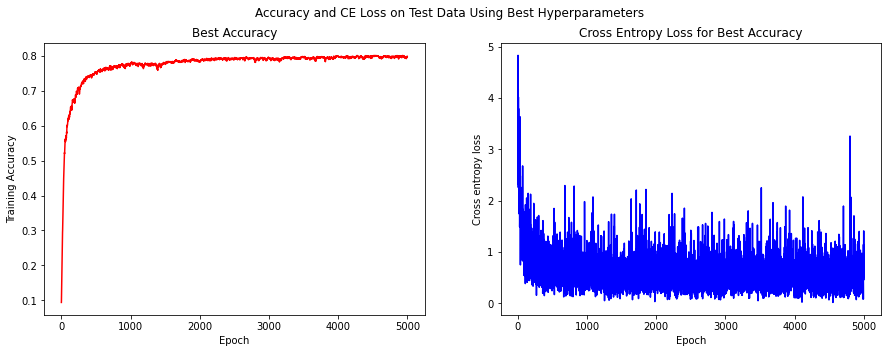

In [ ]:
max_iters = 100
n_features=train_images_reduced.shape[-1]



learning_rates = [.1,.05,.025,.01,.005,.001]
temp = (0,0,0)
batches = [10,20,50,100,200]
 
for rate in learning_rates:
  for batch in batches:
    #initializing new model and optimizer with different learning rate
    model1SGD = MLP(LinearLayer(n_features, 10),SoftmaxOutputLayer())
    opt = GradientDescentOptimizer(model1SGD, rate)
    #fitting model with new batch size
    model1SGD.fit_SGD_no_plot(input= train_images_reduced, output= train_labels_reduced, optimizer=opt, max_iter=max_iters,batch_size=batch)

    y_pred_valid = model1SGD.predict(input=validation_images)
    acc_valid= model1SGD.evaluate_acc(y_true=validation_labels ,y_pred= y_pred_valid)
    #updating tuple if validation accuracy is better than all previous attempts
    if acc_valid > temp[0]:
      temp = (acc_valid,rate,batch)

#Fitting model with the best hyperparameters found and evaluating it on training and testing data
model1SGD = MLP(LinearLayer(n_features, 10),SoftmaxOutputLayer())
opt1SGD = GradientDescentOptimizer(model1SGD, temp[1])

model1SGD.fit_SGD(input= train_images_reduced, output= train_labels_reduced, optimizer=opt1SGD, max_iter=max_iters,batch_size=temp[2])

y_train_pred = model1SGD.predict(input=train_images_reduced)
train_acc_model1SGD= model1SGD.evaluate_acc(y_true=train_labels_reduced ,y_pred= y_train_pred)

y_test_pred = model1SGD.predict(input=test_images_reduced)
test_acc_model1SGD= model1SGD.evaluate_acc(y_true=test_labels ,y_pred= y_test_pred)

print("")
print(f'best learning rate (no hidden layer) = {temp[1]}')
print(f'best batch size (no hidden layer) = {temp[2]}')
print(f'train accuracy (no hidden layer) = {train_acc_model1SGD}')
print(f'validation accuracy (no hidden layer) = {temp[0]}')
print(f'test accuracy (no hidden layer) = {test_acc_model1SGD}')


1 Hidden Layer Relu SGD

100%|██████████| 500/500 [11:54<00:00,  1.43s/it]  



best learning rate (single hidden layer) = 0.1
best batch size (single hidden layer) = 10
train accuracy (single hidden layer) = 0.8397
validation accuracy (single hidden layer) = 0.8368
test accuracy (single hidden layer) = 0.8259


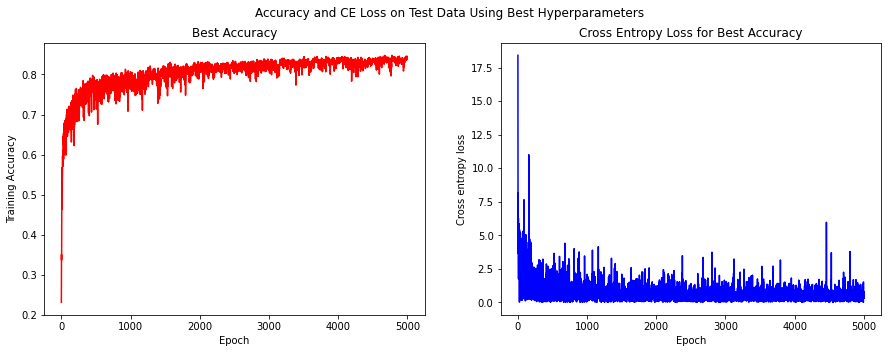

In [ ]:
max_iters = 500
n_features=train_images_reduced.shape[-1]
HIDDEN_SIZE=128


learning_rates = [.1,.05,.025,.01,.005,.001]
temp = (0,0,0)
batches = [10,20,50,100,200]
 
for rate in learning_rates:
  for batch in batches:
    #initializing new model and optimizer with different learning rate
    model2SGD = MLP(LinearLayer(n_features, HIDDEN_SIZE), ReLULayer(), LinearLayer(HIDDEN_SIZE, 10), SoftmaxOutputLayer())
    opt = GradientDescentOptimizer(model2SGD, rate)
    #fitting model with new batch size    
    model2SGD.fit_SGD_no_plot(input= train_images_reduced, output= train_labels_reduced, optimizer=opt, max_iter=max_iters,batch_size=batch)

    y_pred_valid = model2SGD.predict(input=validation_images)
    acc_valid= model2SGD.evaluate_acc(y_true=validation_labels ,y_pred= y_pred_valid)
    #updating tuple if validation accuracy is better than all previous attempts
    if acc_valid > temp[0]:
      temp = (acc_valid,rate,batch)

#Fitting model with the best hyperparameters found and evaluating it on training and testing data
model2SGD = MLP(LinearLayer(n_features, HIDDEN_SIZE), ReLULayer(), LinearLayer(HIDDEN_SIZE, 10), SoftmaxOutputLayer())
opt2SGD = GradientDescentOptimizer(model2SGD, temp[1])

model2SGD.fit_SGD(input= train_images_reduced, output= train_labels_reduced, optimizer=opt2SGD, max_iter=max_iters,batch_size=temp[2])

y_train_pred = model2SGD.predict(input=train_images_reduced)
train_acc_model2= model2SGD.evaluate_acc(y_true=train_labels_reduced ,y_pred= y_train_pred)

y_test_pred = model2SGD.predict(input=test_images_reduced)
test_acc_model2= model2SGD.evaluate_acc(y_true=test_labels ,y_pred= y_test_pred)


print("")
print(f'best learning rate (single hidden layer) = {temp[1]}')
print(f'best batch size (single hidden layer) = {temp[2]}')
print(f'train accuracy (single hidden layer) = {train_acc_model2}')
print(f'validation accuracy (single hidden layer) = {temp[0]}')
print(f'test accuracy (single hidden layer) = {test_acc_model2}')



2 Hidden Layers Relu SGD

100%|██████████| 1000/1000 [34:20<00:00,  2.06s/it]   



best learning rate (2 hidden layers) = 0.025
best batch size (2 hidden layers) = 10
train accuracy (2 hidden layers) = 0.83308
validation accuracy (2 hidden layers) = 0.8313
test accuracy (2 hidden layers) = 0.8169


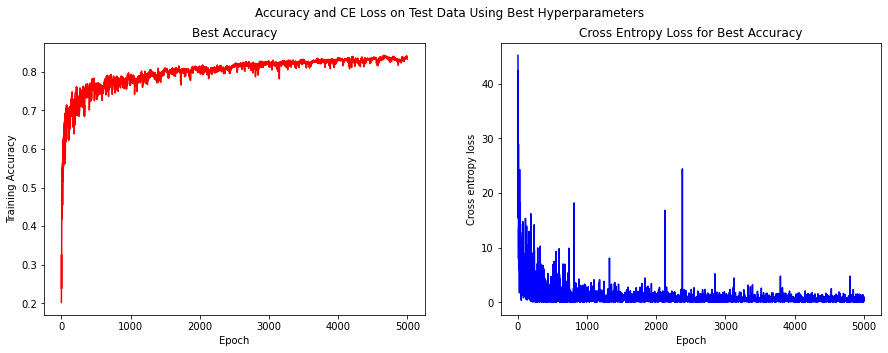

In [ ]:
max_iters = 1000
n_features=train_images_reduced.shape[-1]
HIDDEN_SIZE=128


learning_rates = [.1,.05,.025,.01,.005,.001]
temp = (0,0,0)
batches = [10,20,50,100,200]
 
for rate in learning_rates:
  for batch in batches:
    #initializing new model and optimizer with different learning rate
    model3SGD = MLP(LinearLayer(n_features, HIDDEN_SIZE), ReLULayer(), LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE), ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),SoftmaxOutputLayer())
    opt = GradientDescentOptimizer(model3SGD, rate)
    #fitting model with new batch size
    model3SGD.fit_SGD_no_plot(input= train_images_reduced, output= train_labels_reduced, optimizer=opt, max_iter=max_iters,batch_size=batch)

    y_pred_valid = model3SGD.predict(input=validation_images)
    acc_valid= model3SGD.evaluate_acc(y_true=validation_labels ,y_pred= y_pred_valid)
    #updating tuple if validation accuracy is better than all previous attempts
    if acc_valid > temp[0]:
      temp = (acc_valid,rate,batch)

#Fitting model with the best hyperparameters found and evaluating it on training and testing data
model3SGD = MLP(LinearLayer(n_features, HIDDEN_SIZE), ReLULayer(), LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE), ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),SoftmaxOutputLayer())
opt3SGD = GradientDescentOptimizer(model3SGD, temp[1])

model3SGD.fit_SGD(input= train_images_reduced, output= train_labels_reduced, optimizer=opt3SGD, max_iter=max_iters,batch_size=temp[2])

y_train_pred = model3SGD.predict(input=train_images_reduced)
train_acc_model2= model3SGD.evaluate_acc(y_true=train_labels_reduced ,y_pred= y_train_pred)

y_test_pred = model3SGD.predict(input=test_images_reduced)
test_acc_model2= model3SGD.evaluate_acc(y_true=test_labels ,y_pred= y_test_pred)


print("")
print(f'best learning rate (2 hidden layers) = {temp[1]}')
print(f'best batch size (2 hidden layers) = {temp[2]}')
print(f'train accuracy (2 hidden layers) = {train_acc_model2}')
print(f'validation accuracy (2 hidden layers) = {temp[0]}')
print(f'test accuracy (2 hidden layers) = {test_acc_model2}')



###3.2

2 Hidden Layers Tanh SGD

100%|██████████| 1000/1000 [1:08:45<00:00,  4.13s/it]    



best learning rate (2 hidden layers) = 0.05
best batch size (2 hidden layers) = 10
train accuracy (2 hidden layers) = 0.8345
validation accuracy (2 hidden layers) = 0.824
test accuracy (2 hidden layers) = 0.8117


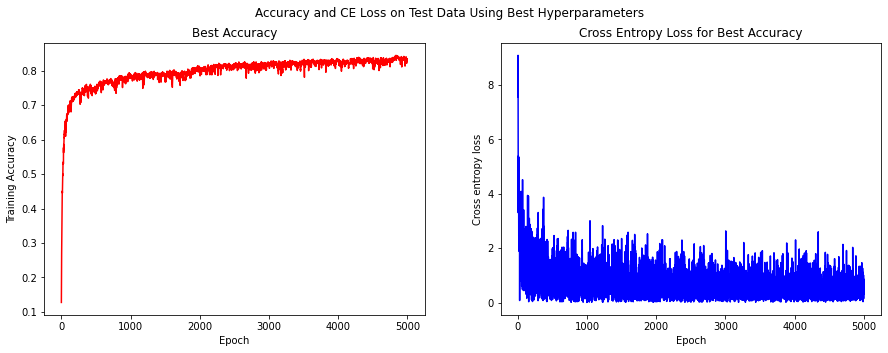

In [15]:
max_iters = 1000
n_features=train_images_reduced.shape[-1]
HIDDEN_SIZE=128


learning_rates = [.1,.05,.025,.01,.005,.001]
temp = (0,0,0)
batches = [10,20,50,100,200]
 
for rate in learning_rates:
  for batch in batches:
    #initializing new model and optimizer with different learning rate
    model3SGD = MLP(LinearLayer(n_features, HIDDEN_SIZE), TanHLayer(), LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    TanHLayer(), LinearLayer(HIDDEN_SIZE, 10), SoftmaxOutputLayer())
    opt = GradientDescentOptimizer(model3SGD, rate)
    #fitting model with new batch size
    model3SGD.fit_SGD_no_plot(input= train_images_reduced, output= train_labels_reduced, optimizer=opt, max_iter=max_iters,batch_size=batch)

    y_pred_valid = model3SGD.predict(input=validation_images)
    acc_valid= model3SGD.evaluate_acc(y_true=validation_labels ,y_pred= y_pred_valid)
    #updating tuple if validation accuracy is better than all previous attempts
    if acc_valid > temp[0]:
      temp = (acc_valid,rate,batch)

#Fitting model with the best hyperparameters found and evaluating it on training and testing data
model3SGD = MLP(LinearLayer(n_features, HIDDEN_SIZE), TanHLayer(), LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    TanHLayer(), LinearLayer(HIDDEN_SIZE, 10), SoftmaxOutputLayer())
opt3SGD = GradientDescentOptimizer(model3SGD, temp[1])

model3SGD.fit_SGD(input= train_images_reduced, output= train_labels_reduced, optimizer=opt3SGD, max_iter=max_iters,batch_size=temp[2])

y_train_pred = model3SGD.predict(input=train_images_reduced)
train_acc_model2= model3SGD.evaluate_acc(y_true=train_labels_reduced ,y_pred= y_train_pred)

y_test_pred = model3SGD.predict(input=test_images_reduced)
test_acc_model2= model3SGD.evaluate_acc(y_true=test_labels ,y_pred= y_test_pred)


print("")
print(f'best learning rate (2 hidden layers) = {temp[1]}')
print(f'best batch size (2 hidden layers) = {temp[2]}')
print(f'train accuracy (2 hidden layers) = {train_acc_model2}')
print(f'validation accuracy (2 hidden layers) = {temp[0]}')
print(f'test accuracy (2 hidden layers) = {test_acc_model2}')

2 Hidden Layers Leaky Relu SGD

100%|██████████| 1000/1000 [51:22<00:00,  3.08s/it]   



best learning rate (2 hidden layers) = 0.1
best batch size (2 hidden layers) = 10
train accuracy (2 hidden layers) = 0.8211
validation accuracy (2 hidden layers) = 0.8332
test accuracy (2 hidden layers) = 0.8051


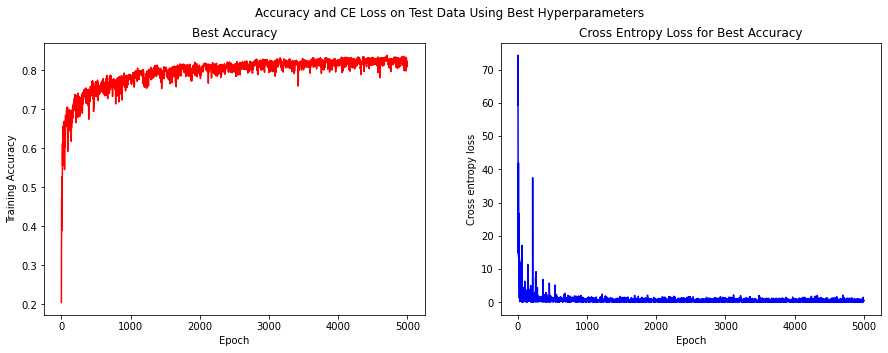

In [ ]:
max_iters = 1000
n_features=train_images_reduced.shape[-1]
HIDDEN_SIZE=128


learning_rates = [.1,.05,.025,.01,.005,.001]
temp = (0,0,0)
batches = [10,20,50,100,200]
 
for rate in learning_rates:
  for batch in batches:
    #initializing new model and optimizer with different learning rate
    model3SGD = MLP(LinearLayer(n_features, HIDDEN_SIZE), LeakyReLULayer(), LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(), LinearLayer(HIDDEN_SIZE, 10), SoftmaxOutputLayer())
    opt = GradientDescentOptimizer(model3SGD, rate)
    #fitting model with new batch size
    model3SGD.fit_SGD_no_plot(input= train_images_reduced, output= train_labels_reduced, optimizer=opt, max_iter=max_iters,batch_size=batch)

    y_pred_valid = model3SGD.predict(input=validation_images)
    acc_valid= model3SGD.evaluate_acc(y_true=validation_labels ,y_pred= y_pred_valid)
    #updating tuple if validation accuracy is better than all previous attempts
    if acc_valid > temp[0]:
      temp = (acc_valid,rate,batch)

#Fitting model with the best hyperparameters found and evaluating it on training and testing data
model3SGD = MLP(LinearLayer(n_features, HIDDEN_SIZE), LeakyReLULayer(), LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
LeakyReLULayer(), LinearLayer(HIDDEN_SIZE, 10), SoftmaxOutputLayer())
opt3SGD = GradientDescentOptimizer(model3SGD, temp[1])

model3SGD.fit_SGD(input= train_images_reduced, output= train_labels_reduced, optimizer=opt3SGD, max_iter=max_iters,batch_size=temp[2])

y_train_pred = model3SGD.predict(input=train_images_reduced)
train_acc_model2= model3SGD.evaluate_acc(y_true=train_labels_reduced ,y_pred= y_train_pred)

y_test_pred = model3SGD.predict(input=test_images_reduced)
test_acc_model2= model3SGD.evaluate_acc(y_true=test_labels ,y_pred= y_test_pred)


print("")
print(f'best learning rate (2 hidden layers) = {temp[1]}')
print(f'best batch size (2 hidden layers) = {temp[2]}')
print(f'train accuracy (2 hidden layers) = {train_acc_model2}')
print(f'validation accuracy (2 hidden layers) = {temp[0]}')
print(f'test accuracy (2 hidden layers) = {test_acc_model2}')

###3.3

2 Hidden Layers regularized ReLU

100%|██████████| 500/500 [21:34<00:00,  2.59s/it]    



best learning rate (2 hidden layers) = 0.01
best batch size (2 hidden layers) = 20
train accuracy (2 hidden layers) = 0.82098
validation accuracy (2 hidden layers) = 0.8209
test accuracy (2 hidden layers) = 0.8108


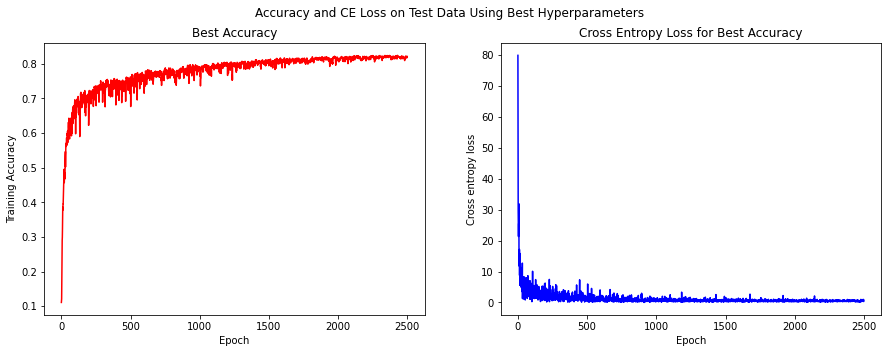

In [ ]:
max_iters = 500
n_features=train_images_reduced.shape[-1]
HIDDEN_SIZE=128

#lambda value
L = .05

learning_rates = [.1,.05,.025,.01,.005,.001]
temp = (0,0,0)
batches = [10,20,50,100,200]
 
for rate in learning_rates:
  for batch in batches:
    #initializing new model and optimizer with different learning rate
    model4SGD = MLP(LinearLayerRegularized(n_features, HIDDEN_SIZE,L), ReLULayer(), LinearLayerRegularized(HIDDEN_SIZE, HIDDEN_SIZE,L),
    ReLULayer(), LinearLayerRegularized(HIDDEN_SIZE, 10, L), SoftmaxOutputLayer())
    opt = GradientDescentOptimizer(model4SGD, rate)
    #fitting model with new batch size
    model4SGD.fit_SGD_no_plot(input= train_images_reduced, output= train_labels_reduced, optimizer=opt, max_iter=max_iters,batch_size=batch)

    y_pred_valid = model4SGD.predict(input=validation_images)
    acc_valid = model4SGD.evaluate_acc(y_true=validation_labels ,y_pred= y_pred_valid)
    #updating tuple if validation accuracy is better than all previous attempts
    if acc_valid > temp[0]:
      temp = (acc_valid,rate,batch)


#Fitting model with the best hyperparameters found and evaluating it on training and testing data
model4SGD = MLP(LinearLayerRegularized(n_features, HIDDEN_SIZE,L), ReLULayer(), LinearLayerRegularized(HIDDEN_SIZE, HIDDEN_SIZE,L),
    ReLULayer(), LinearLayerRegularized(HIDDEN_SIZE, 10, L), SoftmaxOutputLayer())
opt4 = GradientDescentOptimizer(model4SGD, temp[1])


model4SGD.fit_SGD(input= train_images_reduced, output= train_labels_reduced, optimizer=opt4, max_iter=max_iters,batch_size=temp[2])

y_train_pred = model4SGD.predict(input=train_images_reduced)
train_acc_model2= model4SGD.evaluate_acc(y_true=train_labels_reduced ,y_pred= y_train_pred)

y_test_pred = model4SGD.predict(input=test_images_reduced)
test_acc_model2= model4SGD.evaluate_acc(y_true=test_labels ,y_pred= y_test_pred)


print("")
print(f'best learning rate (2 hidden layers) = {temp[1]}')
print(f'best batch size (2 hidden layers) = {temp[2]}')
#print(f'best lambda (2 hidden layers) = {temp[3]}')
print(f'train accuracy (2 hidden layers) = {train_acc_model2}')
print(f'validation accuracy (2 hidden layers) = {temp[0]}')
print(f'test accuracy (2 hidden layers) = {test_acc_model2}')

###3.4

2 Hidden Layers Regularized ReLU with unnormalized images

100%|██████████| 500/500 [40:19<00:00,  4.84s/it]    



best learning rate (2 hidden layers) = 0.005
best batch size (2 hidden layers) = 10
train accuracy (2 hidden layers) = 0.82642
validation accuracy (2 hidden layers) = 0.8319
test accuracy (2 hidden layers) = 0.8131


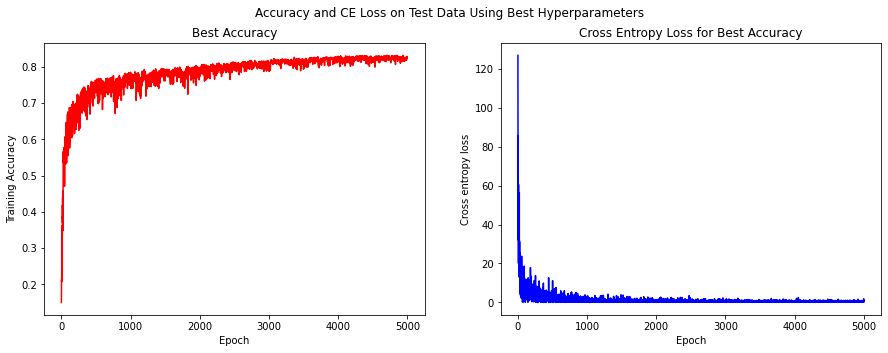

In [ ]:
max_iters = 500
n_features=train_images_reduced.shape[-1]
HIDDEN_SIZE=128

#lambda value
L = .05 

learning_rates = [.1,.05,.025,.01,.005,.001]
temp = (0,0,0)
batches = [10,20,50,100,200]
 
for rate in learning_rates:
  for batch in batches:
    #initializing new model and optimizer with different learning rate
    model4SGD = MLP(LinearLayerRegularized(n_features, HIDDEN_SIZE,L), ReLULayer(), LinearLayerRegularized(HIDDEN_SIZE, HIDDEN_SIZE,L),
    ReLULayer(), LinearLayerRegularized(HIDDEN_SIZE, 10, L), SoftmaxOutputLayer())
    opt = GradientDescentOptimizer(model4SGD, rate)
    #fitting model with new batch size
    model4SGD.fit_SGD_no_plot(input= unnormalized_train, output= unnormalized_train_labels, optimizer=opt, max_iter=max_iters,batch_size=batch)

    y_pred_valid = model4SGD.predict(input=unnormalized_validation_images)
    acc_valid = model4SGD.evaluate_acc(y_true=unnormalized_validation_labels ,y_pred= y_pred_valid)
    #updating tuple if validation accuracy is better than all previous attempts
    if acc_valid > temp[0]:
      temp = (acc_valid,rate,batch)


#Fitting model with the best hyperparameters found and evaluating it on training and testing data
model4SGD = MLP(LinearLayerRegularized(n_features, HIDDEN_SIZE,L), ReLULayer(), LinearLayerRegularized(HIDDEN_SIZE, HIDDEN_SIZE,L),
    ReLULayer(), LinearLayerRegularized(HIDDEN_SIZE, 10, L), SoftmaxOutputLayer())
opt4 = GradientDescentOptimizer(model4SGD, temp[1])


model4SGD.fit_SGD(input= unnormalized_train, output= unnormalized_train_labels, optimizer=opt4, max_iter=max_iters,batch_size=temp[2])

y_train_pred = model4SGD.predict(input=unnormalized_train)
train_acc_model2= model4SGD.evaluate_acc(y_true=unnormalized_train_labels ,y_pred= y_train_pred)

y_test_pred = model4SGD.predict(input=unnormalized_test)
test_acc_model2= model4SGD.evaluate_acc(y_true=test_labels ,y_pred= y_test_pred)



print("")
print(f'best learning rate (2 hidden layers) = {temp[1]}')
print(f'best batch size (2 hidden layers) = {temp[2]}')
print(f'train accuracy (2 hidden layers) = {train_acc_model2}')
print(f'validation accuracy (2 hidden layers) = {temp[0]}')
print(f'test accuracy (2 hidden layers) = {test_acc_model2}')

###3.5

CNN Using Keras

In [10]:
train_images, train_labels, test_images, test_labels, class_names \
           = get_dataset(FASHION=True)  # get Fashion-MNIST datasets


# reshape dataset to have a single channel
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))


# one hot encode target values
Train_labels = to_categorical(train_labels)
Test_labels = to_categorical(test_labels)


Train_images = train_images.astype('float32')/255.0
Test_images = test_images.astype('float32')/255.0



In [11]:
def Keras_model():
 model = Sequential()
 model.add(BatchNormalization())
 model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
 model.add(layers.MaxPooling2D((2, 2)))
 model.add(layers.Conv2D(32, (3, 3), activation='relu'))
 model.add(layers.MaxPooling2D((2, 2)))
 model.add(layers.Flatten())
 model.add(layers.Dense(128, activation='relu'))
 model.add(layers.Dense(10, activation='softmax'))

 opt = SGD(lr=0.01, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [14]:
KerasModel = Keras_model()

history = KerasModel.fit(
    Train_images,
    Train_labels,
    batch_size=60,
    epochs=25,
    validation_data=(Test_images, Test_labels),
)

Epoch 1/25
1000/1000 [==============================] - 6s 5ms/step - loss: 0.8442 - accuracy: 0.6958 - val_loss: 0.5254 - val_accuracy: 0.7946
Epoch 2/25
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4510 - accuracy: 0.8339 - val_loss: 0.4216 - val_accuracy: 0.8461
Epoch 3/25
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3813 - accuracy: 0.8608 - val_loss: 0.3745 - val_accuracy: 0.8667
Epoch 4/25
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3441 - accuracy: 0.8743 - val_loss: 0.3495 - val_accuracy: 0.8728
Epoch 5/25
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3151 - accuracy: 0.8849 - val_loss: 0.3352 - val_accuracy: 0.8810
Epoch 6/25
1000/1000 [==============================] - 4s 4ms/step - loss: 0.2954 - accuracy: 0.8919 - val_loss: 0.3244 - val_accuracy: 0.8782
Epoch 7/25
1000/1000 [==============================] - 4s 4ms/step - loss: 0.2790 - accuracy: 0.8974 - val_loss: 0.3333 - val_accuracy:

Task 3.6 Best MLP Possible

100%|██████████| 1000/1000 [22:42<00:00,  1.36s/it]   



best learning rate (2 hidden layers) = 0.1
best batch size (2 hidden layers) = 20
train accuracy (2 hidden layers) = 0.84096
validation accuracy (2 hidden layers) = 0.8354
test accuracy (2 hidden layers) = 0.8211


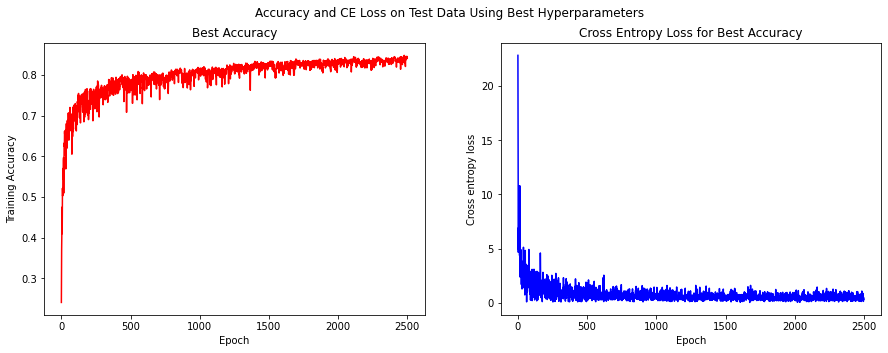

In [ ]:
max_iters = 1000
n_features=train_images_reduced.shape[-1]
HIDDEN_SIZE=96

learning_rates = [.1,.05,.025,.01,.005,.001]
temp = (0,0,0)
batches = [10,20,50,100,200]
 
for rate in learning_rates:
  for batch in batches:
    #initializing new model and optimizer with different learning rate
    model3SGD = MLP(LinearLayer(n_features, HIDDEN_SIZE), TanHLayer(), LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(), LinearLayer(HIDDEN_SIZE, 10), SoftmaxOutputLayer())
    opt = GradientDescentOptimizer(model3SGD, rate)

    #fitting model with new batch size
    model3SGD.fit_SGD_no_plot(input= train_images_reduced, output= train_labels_reduced, optimizer=opt, max_iter=max_iters,batch_size=batch)

    y_pred_valid = model3SGD.predict(input=validation_images)
    acc_valid= model3SGD.evaluate_acc(y_true=validation_labels ,y_pred= y_pred_valid)
    #updating tuple if validation accuracy is better than all previous attempts
    if acc_valid > temp[0]:
      temp = (acc_valid,rate,batch)


#Fitting model with the best hyperparameters found and evaluating it on training and testing data

model3SGD = MLP(LinearLayer(n_features, HIDDEN_SIZE), TanHLayer(), LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(), LinearLayer(HIDDEN_SIZE, 10), SoftmaxOutputLayer())
opt3SGD = GradientDescentOptimizer(model3SGD, temp[1])

model3SGD.fit_SGD(input= train_images_reduced, output= train_labels_reduced, optimizer=opt3SGD, max_iter=max_iters,batch_size=temp[2])

y_train_pred = model3SGD.predict(input=train_images_reduced)
train_acc_model2= model3SGD.evaluate_acc(y_true=train_labels_reduced ,y_pred= y_train_pred)

y_test_pred = model3SGD.predict(input=test_images_reduced)
test_acc_model2= model3SGD.evaluate_acc(y_true=test_labels ,y_pred= y_test_pred)


print("")
print(f'best learning rate (2 hidden layers) = {temp[1]}')
print(f'best batch size (2 hidden layers) = {temp[2]}')
print(f'train accuracy (2 hidden layers) = {train_acc_model2}')
print(f'validation accuracy (2 hidden layers) = {temp[0]}')
print(f'test accuracy (2 hidden layers) = {test_acc_model2}')

ReLU + LeakyReLU = 81.72 accuracy <br>
TanH + LeakyReLU = 82.14 <br>
TanH + LeakyReLU 64 width = 81.63 <br>
TanH + LeakyReLU 96 width = 81.96 <br>
TanH + ReLU = 82.39 <br>
TanH + ReLU 64 width = 81.7 <br>
TanH + ReLU 96 width = 82.46 lr = .1 batch size = 20 <br>
ReLU + TanH = 81.16 <br>
TanH + TanH = 80.45 <br>
LeakyReLU + TanH = 80.19 <br>
LeakyReLU + LeakyReLU = 81.24